In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Solving the rbc model

This worksheet demonstrates how to solve the RBC model with the [dolo](http://econforge.github.io/dolo/) library 
and how to generates impulse responses and stochastic simulations from the solution.

- This notebook is distributed with dolo in : ``examples\notebooks\``. The notebook was opened and run from that directory.
- The model file is in : ``examples\global_models\``

First we import the dolo library.

In [2]:
from dolo import *

The RBC model is defined in a [YAML](http://www.yaml.org/spec/1.2/spec.html#Introduction) file which we can read locally or pull off the web.

In [3]:
# filename = ('https://raw.githubusercontent.com/EconForge/dolo'
#             '/master/examples/models/compat/rbc.yaml')

filename='../models/rbc.yaml'

%cat $filename

name: Real Business Cycle

symbols:

   exogenous: [e_z]
   states: [z, k]
   controls: [n, i]
   expectations: [m]
   values: [V]
   parameters: [beta, sigma, eta, chi, delta, alpha, rho, zbar, sig_z]
   rewards: [u]

definitions:
    y: exp(z)*k^alpha*n^(1-alpha)
    c: y - i
    rk: alpha*y/k
    w: (1-alpha)*y/n

equations:

    arbitrage:
        - chi*n^eta*c^sigma - w                     | 0.0 <= n <= inf
        - 1 - beta*(c/c(1))^(sigma)*(1-delta+rk(1))  | 0.0 <= i <= inf


    transition:
        - z = rho*z(-1) + e_z
        - k = (1-delta)*k(-1) + i(-1)

    value:
        - V = c^(1-sigma)/(1-sigma) - chi*n^(1+eta)/(1+eta) + beta*V(1)

    felicity:
        - u =  c^(1-sigma)/(1-sigma) - chi*n^(1+eta)/(1+eta)

    expectation:
        - m = beta/c(1)^sigma*(1-delta+rk(1))

    direct_response:
        - n = ((1-alpha)*exp(z)*k^alpha*m/chi)^(1/(eta+alpha))
        - i = exp(z)*k^alpha*n^(1-alpha) - (m)^(-1/sigma)

calibration:

    # parameters
    beta : 0.99
    phi: 1
 

`yaml_import(filename)` reads the YAML file and generates a model object. 

In [4]:
model = yaml_import(filename)

The model file already has values for steady-state variables stated in the calibration section so we can go ahead and check that they are correct by computing the model equations at the steady state.

In [5]:
model.residuals()

{'transition': array([0., 0.]),
 'arbitrage': array([-4.4408921e-16,  0.0000000e+00])}

Printing the model also lets us have a look at all the model equations and check that all residual errors are 0 at the steady-state, but with less display prescision.

In [6]:
print( model ) 


        Model:
        ------
        name: "Real Business Cycle"
        type: "dtcc"
        file: "../models/rbc.yaml

Equations:
----------

transition
 1  : 0.0000 : z(0) == (rho) * (z(-(1))) + e_z(0)
 2  : 0.0000 : k(0) == ((1) - (delta)) * (k(-(1))) + i(-(1))

arbitrage
 1  : 0.0000 : (((chi) * ((n(0)) ** (eta))) * ((c(0)) ** (sigma))) - (w(0))
 2  : 0.0000 : (1) - (((beta) * (((c(0)) / (c(1))) ** (sigma))) * ((1) - (delta) + rk(1)))

definitions
 1  : y = exp(z)*k**alpha*n**(1-alpha)
 2  : c = y - i
 3  : rk = alpha*y/k
 4  : w = (1-alpha)*y/n




Next we compute a solution to the model using a first order perturbation method (see the source for the [approximate_controls](https://github.com/EconForge/dolo/blob/master/dolo/algos/perturbation.py) function). The result is a decsion rule object. By decision rule we refer to any object that is callable and maps states to decisions. This particular decision rule object is a TaylorExpansion (see the source for the [TaylorExpansion](https://github.com/EconForge/dolo/blob/master/dolo/numeric/taylor_expansion.py)  class).

In [8]:
dr_pert = perturb(model)

We now compute the global solution (see the source for the [time_iteration](https://github.com/EconForge/dolo/blob/master/dolo/algos/time_iteration.py) function). It returns a decision rule object of type SmolyakGrid (see the source for the [SmolyakGrid](https://github.com/EconForge/dolo/blob/master/dolo/numeric/interpolation/smolyak.py) class).

In [9]:
dr_global = time_iteration(model)

Solving WITH complementarities.
------------------------------------------------
| N   |  Error     | Gain     | Time     | nit |
------------------------------------------------
|   1 |  6.178e-01 |      nan |    1.744 |   8 |
|   2 |  1.571e-01 |    0.254 |    0.052 |   5 |
|   3 |  1.019e-01 |    0.649 |    0.053 |   5 |
|   4 |  7.094e-02 |    0.696 |    0.042 |   4 |
|   5 |  5.213e-02 |    0.735 |    0.044 |   4 |
|   6 |  3.972e-02 |    0.762 |    0.050 |   4 |
|   7 |  3.108e-02 |    0.783 |    0.043 |   4 |
|   8 |  2.484e-02 |    0.799 |    0.044 |   4 |
|   9 |  2.019e-02 |    0.813 |    0.043 |   4 |
|  10 |  1.664e-02 |    0.824 |    0.044 |   4 |
|  11 |  1.387e-02 |    0.834 |    0.035 |   3 |
|  12 |  1.169e-02 |    0.842 |    0.035 |   3 |
|  13 |  9.931e-03 |    0.850 |    0.034 |   3 |
|  14 |  8.692e-03 |    0.875 |    0.033 |   3 |
|  15 |  7.784e-03 |    0.896 |    0.032 |   3 |
|  16 |  6.989e-03 |    0.898 |    0.033 |   3 |
|  17 |  6.293e-03 |    0.900 |    0.

# Decision rule

Here we plot optimal investment and labour for different levels of capital (see the source for the [plot_decision_rule](https://github.com/EconForge/dolo/blob/master/dolo/algos/simulations.py) function).

In [10]:
tab_global = tabulate(model, dr_global, 'k')
tab_pert = tabulate(model, dr_pert, 'k')

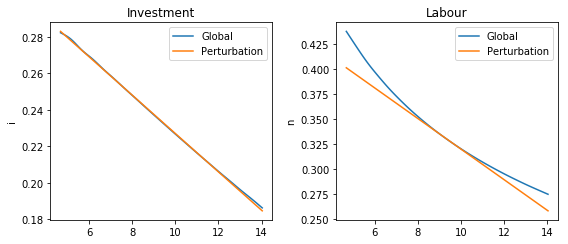

In [11]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8,3.5))

plt.subplot(121)
plt.plot(tab_global['k'], tab_global['i'], label='Global')
plt.plot(tab_pert['k'], tab_pert['i'], label='Perturbation')
plt.ylabel('i')
plt.title('Investment')
plt.legend()

plt.subplot(122)
plt.plot(tab_global['k'], tab_global['n'], label='Global')
plt.plot(tab_pert['k'], tab_pert['n'], label='Perturbation')
plt.ylabel('n')
plt.title('Labour')
plt.legend()

plt.tight_layout()

It would seem, according to this, that second order perturbation does very well for the RBC model. We will revisit this issue more rigorously when we explore the deviations from the model's arbitrage section equations.

Let us repeat the calculation of investment decisions for various values of the depreciation rate, $\delta$. Note that this is a comparative statics exercise, even though the models compared are dynamic.

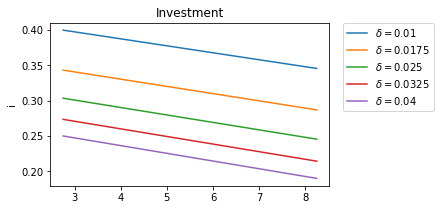

In [13]:
original_delta = model.calibration['delta'] 

drs = []
delta_values = np.linspace(0.01, 0.04,5)
for val in delta_values:
    model.set_calibration(delta=val)
    drs.append(perturb(model))

    
plt.figure(figsize=(5,3))

for i,dr in enumerate(drs):
    sim = tabulate(model, dr,'k')
    plt.plot(sim['k'],sim['i'], label='$\delta={}$'.format(delta_values[i]))
plt.ylabel('i')
plt.title('Investment')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

model.set_calibration(delta=original_delta)

We find that more durable capital leads to higher steady state investment and slows the rate of convergence for capital (the slopes are roughly the same, which implies that relative to steady state capital investment responds stronger at higher $\delta$; this is in addition to the direct effect of depreciation).

# Use the model to simulate

We will use the deterministic steady-state as a starting point.

In [14]:
s0 = model.calibration['states']
print(str(model.symbols['states'])+'='+str(s0))

['z', 'k']=[ 0.         21.49753444]


We also get the covariance matrix just in case. This is a one shock model so all we have is the variance of $e_z$.

In [15]:
sigma2_ez = model.exogenous.Sigma
sigma2_ez

array([[0.000256]])

## Impulse response functions

Consider a 10% shock to productivity.

In [16]:
s1 = s0.copy()
s1[0] *= 1.1
print(str(model.symbols['states'])+'='+str(s1))

['z', 'k']=[ 0.         21.49753444]


The `simulate` function is used both to trace impulse response functions and to compute stochastic simulations. Choosing `n_exp>=1`, will result in that many "stochastic" simulations. With `n_exp = 0`, we get one single simulation without any stochastic shock (see the source for the [simulate](https://github.com/EconForge/dolo/blob/master/dolo/algos/simulations.py) function). 
The output is a panda table of size $H \times n_v$ where $n_v$ is the number of variables in the model and $H$ the number of dates.

In [17]:
simulate(model, dr, N=10, T=40)

<xarray.DataArray (T: 40, N: 10, V: 9)>
array([[[-8.215569e-03,  0.000000e+00, ...,           nan,           nan],
        [-3.052676e-02,  0.000000e+00, ...,           nan,           nan],
        ...,
        [ 5.492295e-03,  0.000000e+00, ...,           nan,           nan],
        [-1.727065e-03,  0.000000e+00, ...,           nan,           nan]],

       [[ 3.441022e-02, -8.215569e-03, ...,           nan,           nan],
        [-2.093615e-02, -3.052676e-02, ...,           nan,           nan],
        ...,
        [-7.392879e-03,  5.492295e-03, ...,           nan,           nan],
        [ 2.368904e-02, -1.727065e-03, ...,           nan,           nan]],

       ...,

       [[-1.266916e-02,  1.287402e-02, ...,  5.953791e-03,  4.934772e+00],
        [ 2.485331e-02, -5.501611e-02, ...,  6.720710e-03,  4.200902e+00],
        ...,
        [-2.854673e-02, -4.841336e-02, ...,  6.531119e-03,  4.302724e+00],
        [-1.180261e-02,  8.695070e-03, ...,  6.717241e-03,  4.621156e+00]],

  

In [18]:
from dolo.algos.simulations import response

In [19]:
m0 = model.calibration["exogenous"]

In [20]:
s0 = model.calibration["states"]

In [21]:
dr_global.eval_ms(m0, s0)

array([0.20526859, 0.1103993 ])

In [22]:
irf = response(model,dr_global, 'e_z')


Let us plot the response of consumption and investment.

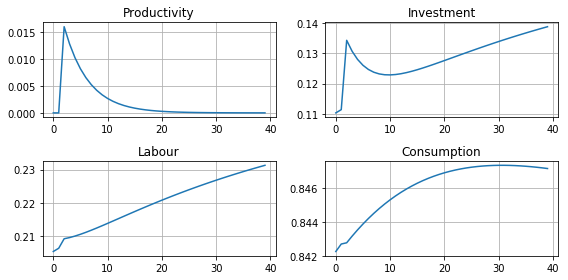

In [23]:
plt.figure(figsize=(8,4))
plt.subplot(221)
plt.plot(irf.sel(V='z'))
plt.title('Productivity')
plt.grid()
plt.subplot(222)
plt.plot(irf.sel(V='i'))
plt.title('Investment')
plt.grid()
plt.subplot(223)
plt.plot(irf.sel(V='n'))
plt.grid()
plt.title('Labour')
plt.subplot(224)
plt.plot(irf.sel(V='c'))
plt.title('Consumption')
plt.grid()
plt.tight_layout()

Note that the plotting is made using the wonderful [matplotlib](http://matplotlib.org/users/pyplot_tutorial.html) library. Read the online [tutorials](http://matplotlib.org/users/beginner.html) to learn how to customize the plots to your needs (e.g., using [latex](http://matplotlib.org/users/usetex.html) in annotations). If instead you would like to produce charts in Matlab, you can easily export the impulse response functions, or any other matrix, to a `.mat` file.

    A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.


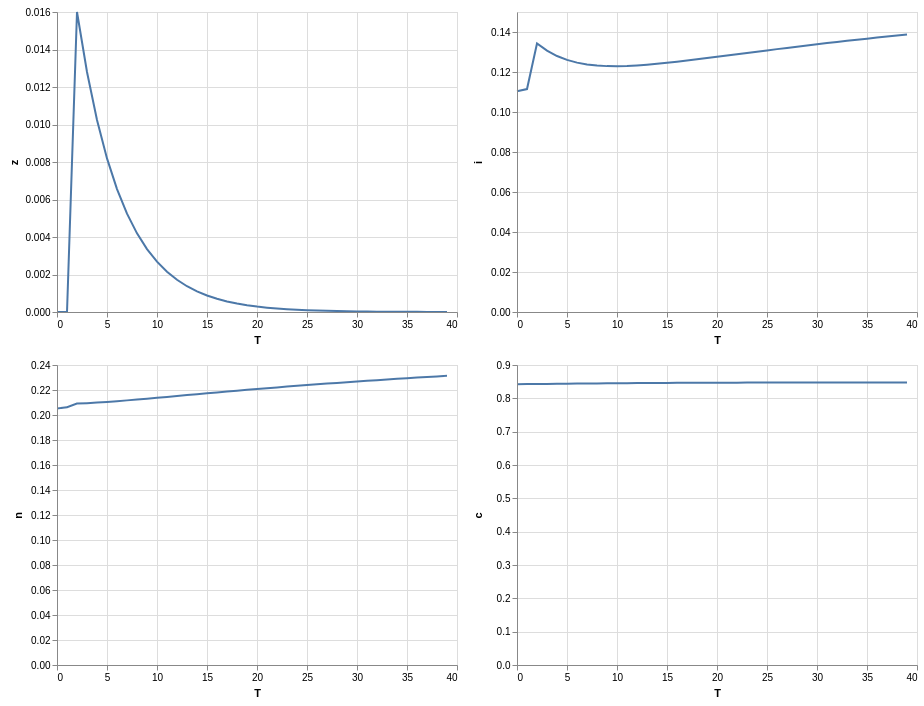

In [24]:
# it is also possible (and fun) to use the graph visualization altair lib instead:
# it is not part of dolo dependencies. To install `conda install -c conda-forge altair`
import altair as alt
df = irf.drop('N').to_pandas().reset_index() # convert to flat database
base = alt.Chart(df).mark_line()
ch1 = base.encode(x='T', y='z')
ch2 = base.encode(x='T', y='i')
ch3 = base.encode(x='T', y='n')
ch4 = base.encode(x='T', y='c')
(ch1|ch2)& \
(ch3|ch4)

In [25]:
irf_array = np.array( irf )
import scipy.io
scipy.io.savemat("export.mat", {'table': irf_array} )

## Stochastic simulations

Now we run 1000 random simulations.  The result is an array of size $T\times N \times n_v$ where 
- $T$ the number of dates
- $N$ the number of simulations
- $n_v$ is the number of variables


In [26]:
sim = simulate(model, dr_global, N=1000, T=40 )
print(sim.shape)

(40, 1000, 9)


We plot the responses of consumption, investment and labour to the stochastic path of productivity.

    
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


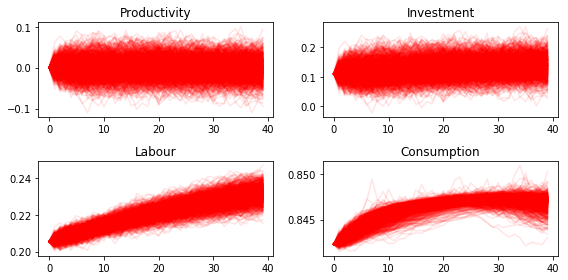

In [27]:
plt.figure(figsize=(8,4))
for i in range(1000):
    plt.subplot(221)
    plt.plot(sim.sel(N=i,V='z'), color='red', alpha=0.1)
    plt.subplot(222)
    plt.plot(sim.sel(N=i,V='i'), color='red', alpha=0.1)
    plt.subplot(223)
    plt.plot(sim.sel(N=i,V='n'), color='red', alpha=0.1)
    plt.subplot(224)
    plt.plot(sim.sel(N=i,V='c'), color='red', alpha=0.1)

plt.subplot(221)
plt.title('Productivity')
plt.subplot(222)
plt.title('Investment')
plt.subplot(223)
plt.title('Labour')
plt.subplot(224)
plt.title('Consumption')

plt.tight_layout()

We find that while the distribution of investment and labour converges quickly to the ergodic distribution, that of consumption takes noticeably longer. This is indicative of higher persistence in consumption, which in turn could be explained by permanent income considerations.

# Descriptive statistics
A common way to evaluate the success of the RBC model is in its ability to mimic patterns in the descriptive statistics of the real economy. Let us compute some of these descriptive statistics from our sample of stochastic simulations. First we compute growth rates:

In [28]:
dsim = sim / sim.shift(T=1)

Then we compute the volatility of growth rates for each simulation:

In [29]:
volat = dsim.std(axis=1)
print(volat.shape)

(40, 9)


In [30]:
volat

<xarray.DataArray (T: 40, V: 9)>
array([[         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [1.610460e+01,          nan, 7.216450e-15, ..., 4.263814e-04,
        2.191723e-02, 1.264240e-02],
       [1.618588e+01, 1.610460e+01, 9.880539e-04, ..., 4.002167e-04,
        2.324016e-02, 1.308931e-02],
       ...,
       [1.354310e+01, 3.780695e+01, 1.826828e-03, ..., 3.710962e-04,
        2.382253e-02, 1.339413e-02],
       [3.541631e+01, 1.094721e+01, 1.790904e-03, ..., 3.681102e-04,
        2.234791e-02, 1.265644e-02],
       [7.612170e+01, 6.075938e+01, 1.784252e-03, ..., 3.928456e-04,
        2.346935e-02, 1.335695e-02]])
Coordinates:
  * T        (T) int64 0 1 2 3 4 5 6 7 8 9 10 ... 30 31 32 33 34 35 36 37 38 39
  * V        (V) <U3 'e_z' 'z' 'k' 'n' 'i' 'y' 'c' 'rk' 'w'

Then we compute the mean and a confidence interval for each variable. In the generated table the first column contains the standard deviations of growth rates. The second and third columns contain the lower and upper bounds of the 95% confidence intervals, respectively.

In [31]:
table = np.column_stack([
    volat.mean(axis=0),
    volat.mean(axis=0)-1.96*volat.std(axis=0),
    volat.mean(axis=0)+1.96*volat.std(axis=0)  ])
table

array([[ 6.00442420e+01, -5.53075009e+01,  1.75395985e+02],
       [ 1.02137895e+02, -3.76106170e+02,  5.80381961e+02],
       [ 1.62456810e-03,  1.02685580e-03,  2.22228040e-03],
       [ 9.94873045e-03,  9.34263387e-03,  1.05548270e-02],
       [ 2.87402526e-01, -3.10015665e-01,  8.84820717e-01],
       [ 2.32474744e-02,  2.20662616e-02,  2.44286872e-02],
       [ 2.57640173e-04,  8.12910401e-05,  4.33989306e-04],
       [ 2.39133107e-02,  2.26207937e-02,  2.52058278e-02],
       [ 1.33947836e-02,  1.27143133e-02,  1.40752539e-02]])

We can use the [pandas](http://pandas.pydata.org/pandas-docs/stable/10min.html) library to present the results in a nice table.

In [32]:
import pandas
df = pandas.DataFrame(table, index=sim.V, 
                      columns=['Growth rate std.',
                               'Lower 95% bound',
                               'Upper 95% bound' ])
pandas.set_option('precision', 4)
df

,Growth rate std.,Lower 95% bound,Upper 95% bound
V,,,
e_z,60.0442,-5.5308e+01,175.3960
z,102.1379,-3.7611e+02,580.3820
k,0.0016,1.0269e-03,0.0022
n,0.0099,9.3426e-03,0.0106
i,0.2874,-3.1002e-01,0.8848
y,0.0232,2.2066e-02,0.0244
c,0.0003,8.1291e-05,0.0004
rk,0.0239,2.2621e-02,0.0252
w,0.0134,1.2714e-02,0.0141


# Error measures
<mark>Marked text</mark>


It is always important to get a handle on the accuracy of the solution. The `omega` function computes and aggregates the errors for the model's arbitrage section equations. For the RBC model these are the investment demand and labor supply equations. For each equation it reports the maximum error over the domain and the mean error using ergodic distribution weights (see the source for the [omega](https://github.com/EconForge/dolo/blob/master/dolo/algos/fg/accuracy.py) function).

In [33]:
from dolo.algos.accuracy import omega

print("Perturbation solution")
err_pert = omega(model, dr_pert)
err_pert

ModuleNotFoundError: No module named 'dolo.algos.accuracy'

In [34]:
print("Global solution")
err_global=omega(model, dr_global)
err_global

Global solution


NameError: name 'omega' is not defined

The result of `omega` is a subclass of `dict`. `omega` fills that dict with some useful information that the default print does not reveal:

In [ ]:
err_pert.keys()

In particular the domain field  contains information, like bounds and shape, that we can use to plot the spatial pattern of errors.

In [ ]:
a = err_pert['domain'].a
b = err_pert['domain'].b
orders = err_pert['domain'].orders
errors = concatenate((err_pert['errors'].reshape( orders.tolist()+[-1] ),
                      err_global['errors'].reshape( orders.tolist()+[-1] )),
                     2)

figure(figsize=(8,6))

titles=["Investment demand pertubation errors",
        "Labor supply pertubation errors",
        "Investment demand global errors",
        "Labor supply global errors"]

for i in range(4):

    subplot(2,2,i+1)
    imgplot = imshow(errors[:,:,i], origin='lower', 
                     extent=( a[0], b[0], a[1], b[1]), aspect='auto')
    imgplot.set_clim(0,3e-4)
    colorbar()
    xlabel('z')
    ylabel('k')
    title(titles[i])

tight_layout()